In [1]:
!pip install xgboost catboost lightgbm
!pip install -U imbalanced-learn
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, roc_auc_score, classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTENC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier



from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.pipeline import Pipeline

In [3]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [4]:
DATA_PATH = "/content/data/MyDrive/SKN 10기/최종 프로젝트/"
df = pd.read_csv(DATA_PATH + "customer_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [8]:
df.loc[df['TotalCharges'].isna(),'TotalCharges']=df['tenure']*df['MonthlyCharges']    # 결측치 처리

In [9]:
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1e-5)

df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1e-5)

In [10]:
df['charge_increased'] = (df['MonthlyCharges'] > df['NEW_AVG_Charges']).astype(int)

In [11]:
df['charge_growth_rate'] = (df['MonthlyCharges'] - df['NEW_AVG_Charges']) / (df['NEW_AVG_Charges'] + 1e-5)

In [12]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,charge_increased,charge_growth_rate
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,No,1,29.849702,0.999990,29.849702,1,0.000010
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.50,No,3,55.573513,0.975830,18.983270,1,0.024769
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,Yes,3,54.074730,1.004173,17.949940,0,-0.004156
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,No,3,40.905546,0.967034,14.099953,1,0.034090
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,Yes,1,75.824621,1.072484,70.699293,0,-0.067585


In [13]:
customer_ids = df["customerID"]

In [14]:
df.columns = df.columns.str.lower()
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,paymentmethod,monthlycharges,totalcharges,churn,new_totalservices,new_avg_charges,new_increase,new_avg_service_fee,charge_increased,charge_growth_rate
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,No,1,29.849702,0.999990,29.849702,1,0.000010
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.50,No,3,55.573513,0.975830,18.983270,1,0.024769
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,Yes,3,54.074730,1.004173,17.949940,0,-0.004156
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,No,3,40.905546,0.967034,14.099953,1,0.034090
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,Yes,1,75.824621,1.072484,70.699293,0,-0.067585


In [15]:
df['is_auto_payment'] = df['paymentmethod'].apply(lambda x: int('automatic' in x.lower() or 'bank' in x.lower()))
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,monthlycharges,totalcharges,churn,new_totalservices,new_avg_charges,new_increase,new_avg_service_fee,charge_increased,charge_growth_rate,is_auto_payment
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,29.85,29.85,No,1,29.849702,0.999990,29.849702,1,0.000010,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,56.95,1889.50,No,3,55.573513,0.975830,18.983270,1,0.024769,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,53.85,108.15,Yes,3,54.074730,1.004173,17.949940,0,-0.004156,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,42.30,1840.75,No,3,40.905546,0.967034,14.099953,1,0.034090,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,70.70,151.65,Yes,1,75.824621,1.072484,70.699293,0,-0.067585,0


In [16]:
# 변환할 이진형 컬럼 목록
binary_cols = ['partner', 'dependents','phoneservice', 'paperlessbilling', 'churn']

# 변환 딕셔너리 정의
yes_no_map = {'Yes': 1, 'No': 0}

# 변환 적용
for col in binary_cols:
    df[col] = df[col].map(yes_no_map)
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,monthlycharges,totalcharges,churn,new_totalservices,new_avg_charges,new_increase,new_avg_service_fee,charge_increased,charge_growth_rate,is_auto_payment
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,29.85,29.85,0,1,29.849702,0.999990,29.849702,1,0.000010,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,56.95,1889.50,0,3,55.573513,0.975830,18.983270,1,0.024769,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,53.85,108.15,1,3,54.074730,1.004173,17.949940,0,-0.004156,0
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,42.30,1840.75,0,3,40.905546,0.967034,14.099953,1,0.034090,1
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,70.70,151.65,1,1,75.824621,1.072484,70.699293,0,-0.067585,0


In [17]:
contract_map = {
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
}
df['expected_contract_months'] = df['contract'].map(contract_map)
df['contract_gap'] = df['expected_contract_months'] - df['tenure']

In [18]:
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].astype('category')

In [19]:
df.dtypes

,0
customerid,category
gender,category
seniorcitizen,int64
partner,int64
dependents,int64
tenure,int64
phoneservice,int64
multiplelines,category
internetservice,category
onlinesecurity,category


lgbm_best_params = {
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 3,
    "num_leaves": 31,
    "subsample": 0.8,
    "random_state": 42,
    "verbosity": -1
}
cat_best_params = {
    "iterations": 200,
    "depth": 8,
    "learning_rate": 0.05,
    "verbose": 0,
    "random_state": 42
}
xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 1.0,
    "colsample_bytree": 0.8,
    "gamma": 0,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": 42
}

In [20]:
df.drop(columns=["gender","streamingtv","deviceprotection","internetservice","streamingmovies"],inplace=True)

In [21]:
df.head()

,customerid,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,techsupport,...,churn,new_totalservices,new_avg_charges,new_increase,new_avg_service_fee,charge_increased,charge_growth_rate,is_auto_payment,expected_contract_months,contract_gap
0,7590-VHVEG,0,1,0,1,0,No phone service,No,Yes,No,...,0,1,29.849702,0.999990,29.849702,1,0.000010,0,1,0
1,5575-GNVDE,0,0,0,34,1,No,Yes,No,No,...,0,3,55.573513,0.975830,18.983270,1,0.024769,0,12,-22
2,3668-QPYBK,0,0,0,2,1,No,Yes,Yes,No,...,1,3,54.074730,1.004173,17.949940,0,-0.004156,0,1,-1
3,7795-CFOCW,0,0,0,45,0,No phone service,Yes,No,Yes,...,0,3,40.905546,0.967034,14.099953,1,0.034090,1,12,-33
4,9237-HQITU,0,0,0,2,1,No,No,No,No,...,1,1,75.824621,1.072484,70.699293,0,-0.067585,0,1,-1


In [45]:
df.dtypes

,0
customerid,category
seniorcitizen,int64
partner,int64
dependents,int64
tenure,int64
phoneservice,int64
multiplelines,category
onlinesecurity,category
onlinebackup,category
techsupport,category


In [22]:
# 1. 데이터 준비
X = df.drop(columns=['churn',"customerid"])
y = df['churn']

# 2. 범주형 인코딩
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.15, stratify=y, random_state=42
)

# 4. 최적 하이퍼파라미터 기반 모델 정의
lgbm_best_params = {
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 3,
    "num_leaves": 31,
    "subsample": 0.8,
    "random_state": 42,
    "verbosity": -1
}
cat_best_params = {
    "iterations": 200,
    "depth": 8,
    "learning_rate": 0.05,
    "verbose": 0,
    "random_state": 42
}
xgb_best_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 1.0,
    "colsample_bytree": 0.8,
    "gamma": 0,
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": 42
}

lgbm_model = LGBMClassifier(**lgbm_best_params)
cat_model = CatBoostClassifier(**cat_best_params)
xgb_model = XGBClassifier(**xgb_best_params)

# 앙상블 모델 정의
ensemble_model = VotingClassifier(
    estimators=[('lgbm', lgbm_model), ('cat', cat_model), ('xgb', xgb_model)],
    voting='soft',
    weights=[1, 3, 1],
    n_jobs=-1
)

# 5. 전체 데이터로 재학습 (SMOTENC 포함)
pipeline_final = Pipeline([
    ('smote', SMOTENC(categorical_features=categorical_indices, random_state=42)),
    ('model', ensemble_model)
])
pipeline_final.fit(X, y)

# 6. 테스트 데이터 평가 (threshold 고정)
final_threshold = 0.312
y_test_proba = pipeline_final.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= final_threshold).astype(int)

results_df = pd.DataFrame({
    "customerID": id_test,
    "churn_probability": y_test_proba,
    "actual": y_test,
    "predicted": y_test_pred
})

n = int(input("몇 명의 이탈 위험 고객을 보여드릴까요? "))  # 사용자 입력

top_churners = results_df.sort_values(by="churn_probability", ascending=False).head(n)

print(f"📊 이탈 가능성이 높은 고객 Top {n}:")
for _, row in top_churners.iterrows():
    print(f"- 고객 ID: {row['customerID']} (이탈 확률: {row['churn_probability']*100:.2f}%)")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


몇 명의 이탈 위험 고객을 보여드릴까요? 15
📊 이탈 가능성이 높은 고객 Top 15:
- 고객 ID: 0295-PPHDO (이탈 확률: 96.56%)
- 고객 ID: 9248-OJYKK (이탈 확률: 96.08%)
- 고객 ID: 1768-ZAIFU (이탈 확률: 95.36%)
- 고객 ID: 5178-LMXOP (이탈 확률: 95.33%)
- 고객 ID: 0970-ETWGE (이탈 확률: 94.28%)
- 고객 ID: 1400-MMYXY (이탈 확률: 93.97%)
- 고객 ID: 3722-WPXTK (이탈 확률: 93.85%)
- 고객 ID: 6230-BSUXY (이탈 확률: 93.67%)
- 고객 ID: 6857-VWJDT (이탈 확률: 93.24%)
- 고객 ID: 1820-TQVEV (이탈 확률: 93.08%)
- 고객 ID: 4415-IJZTP (이탈 확률: 93.02%)
- 고객 ID: 2609-IAICY (이탈 확률: 92.79%)
- 고객 ID: 8375-DKEBR (이탈 확률: 92.64%)
- 고객 ID: 5376-DEQCP (이탈 확률: 92.29%)
- 고객 ID: 9057-SIHCH (이탈 확률: 92.24%)


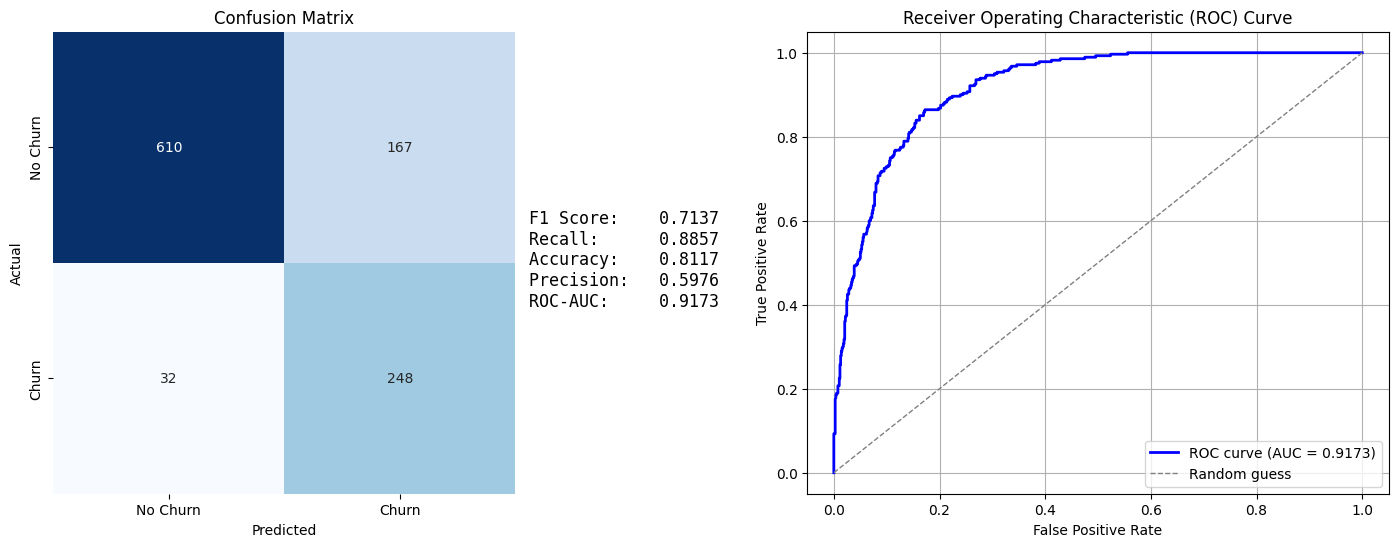

In [23]:
# 혼동 행렬 및 ROC 계산
cm = confusion_matrix(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# 성능 지표 계산
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

# subplot 구성
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# [왼쪽] Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'],
            ax=axes[0], cbar=False)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')
axes[0].set_box_aspect(1)

# [오른쪽] ROC Curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True)

# 그래프 간 간격
plt.subplots_adjust(wspace=0.4)

# 성능 지표 텍스트로 삽입 (figure 전체 좌표 기준, 0~1)
metrics_text = (
    f"F1 Score:    {f1:.4f}\n"
    f"Recall:      {recall:.4f}\n"
    f"Accuracy:    {accuracy:.4f}\n"
    f"Precision:   {precision:.4f}\n"
    f"ROC-AUC:     {roc_auc:.4f}"
)
plt.figtext(0.475, 0.5, metrics_text, ha='center', va='center', fontsize=12, fontfamily='monospace')

plt.show()

                     Feature  Importance
13              totalcharges   50.063770
12            monthlycharges   41.125620
15           new_avg_charges   35.351201
3                     tenure   31.784322
22              contract_gap   30.950242
17       new_avg_service_fee   29.629166
16              new_increase   29.552649
21  expected_contract_months   25.349073
20           is_auto_payment   24.464445
19        charge_growth_rate   21.490074
10          paperlessbilling   18.636696
11             paymentmethod   18.410757
0              seniorcitizen   18.381203
1                    partner   16.157175
2                 dependents   15.909191
18          charge_increased   15.518937
6             onlinesecurity   13.124424
4               phoneservice   10.982020
8                techsupport    9.977212
9                   contract    7.604388
7               onlinebackup    7.155954
5              multiplelines    6.242135
14         new_totalservices    5.139345


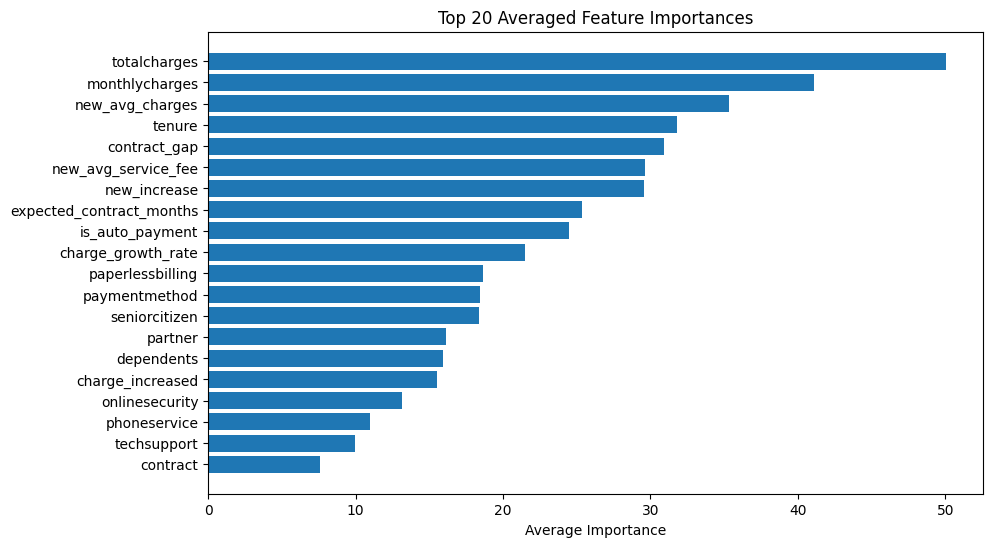

In [24]:
# 각 모델에서 feature importance 추출
lgbm_importances = ensemble_model.named_estimators_['lgbm'].feature_importances_
cat_importances = ensemble_model.named_estimators_['cat'].get_feature_importance()
xgb_importances = ensemble_model.named_estimators_['xgb'].feature_importances_

# 배열로 변환 후 평균 계산 (또는 가중 평균도 가능)
avg_importances = np.mean(
    [lgbm_importances, cat_importances, xgb_importances], axis=0
)

# DataFrame으로 정리
feature_names = df.drop(columns=['churn','customerid']).columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

# 출력
print(feat_imp_df)

# 시각화 (상위 20개)
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
plt.title("Top 20 Averaged Feature Importances")
plt.xlabel("Average Importance")
plt.show()


In [29]:
df.columns

Index(['customerid', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'onlinesecurity', 'onlinebackup',
       'techsupport', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn', 'new_totalservices',
       'new_avg_charges', 'new_increase', 'new_avg_service_fee',
       'charge_increased', 'charge_growth_rate', 'is_auto_payment',
       'expected_contract_months', 'contract_gap'],
      dtype='object')

In [49]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# 먼저 df에서 feature 준비
X = df.drop(columns=["churn", "customerid"])  # df는 DataFrame 상태여야 함
y = df["churn"]

# categorical_cols 지정
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# LabelEncoder 저장용 딕셔너리
label_encoders = {}

# 🎯 여기서 X는 반드시 DataFrame 상태여야 함!
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# 👇 여기서부터 넘파이로 변환해도 OK!
X = X.to_numpy()
y = y.to_numpy()

# 이후 pipeline 학습 및 저장
joblib.dump(pipeline_final, "/content/data/MyDrive/SKN 10기/최종 프로젝트/churn_predictor_pipeline.pkl")
joblib.dump(label_encoders, "/content/data/MyDrive/SKN 10기/최종 프로젝트/label_encoders.pkl")
joblib.dump(categorical_cols, "/content/data/MyDrive/SKN 10기/최종 프로젝트/categorical_cols.pkl")


['/content/data/MyDrive/SKN 10기/최종 프로젝트/categorical_cols.pkl']

In [51]:
import pandas as pd
import joblib

# 모델과 전처리 정보 로드
model = joblib.load("/content/data/MyDrive/SKN 10기/최종 프로젝트/churn_predictor_pipeline.pkl")
label_encoders = joblib.load("/content/data/MyDrive/SKN 10기/최종 프로젝트/label_encoders.pkl")
categorical_cols = joblib.load("/content/data/MyDrive/SKN 10기/최종 프로젝트/categorical_cols.pkl")

# 새로운 입력 데이터
sample_user = pd.read_csv("/content/data/MyDrive/SKN 10기/최종 프로젝트/sample_user.csv")  # 또는 직접 만든 DataFrame

# 이진형 Yes/No 변환 (학습 시 map으로 처리했던 것들)
binary_cols = ['partner', 'dependents', 'phoneservice', 'paperlessbilling']

yes_no_map = {'Yes': 1, 'No': 0}
for col in binary_cols:
    if col in sample_user.columns:
        sample_user[col] = sample_user[col].map(yes_no_map)

# categorical_cols만 LabelEncoder 적용
for col in categorical_cols:
    sample_user[col] = sample_user[col].astype(str)
    sample_user[col] = label_encoders[col].transform(sample_user[col])

# 검증
non_numeric_cols = sample_user.select_dtypes(include=["object", "category"]).columns.tolist()
if non_numeric_cols:
    print("🚨 문자열 컬럼 남아 있음:", non_numeric_cols)
else:
    print("✅ 모든 컬럼 숫자형 변환 완료!")

# 예측
X_sample = sample_user.to_numpy()
proba = model.predict_proba(X_sample)[:, 1]
pred = (proba >= 0.312).astype(int)

print("이탈 확률:", proba)
print("예측 결과:", pred)



✅ 모든 컬럼 숫자형 변환 완료!
이탈 확률: [0.78665592]
예측 결과: [1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [53]:
import pandas as pd
import joblib

# 데이터 로드
model = joblib.load("/content/data/MyDrive/SKN 10기/최종 프로젝트/churn_predictor_pipeline.pkl")
label_encoders = joblib.load("/content/data/MyDrive/SKN 10기/최종 프로젝트/label_encoders.pkl")
categorical_cols = joblib.load("/content/data/MyDrive/SKN 10기/최종 프로젝트/categorical_cols.pkl")

# batch 데이터 로딩
batch_users = pd.read_csv("/content/data/MyDrive/SKN 10기/최종 프로젝트/sample_users_30.csv")

# 이진형 Yes/No 처리
binary_cols = ['partner', 'dependents', 'phoneservice', 'paperlessbilling']
yes_no_map = {'Yes': 1, 'No': 0}
for col in binary_cols:
    if col in batch_users.columns:
        batch_users[col] = batch_users[col].map(yes_no_map)

# LabelEncoder 처리
for col in categorical_cols:
    batch_users[col] = batch_users[col].astype(str)
    batch_users[col] = label_encoders[col].transform(batch_users[col])

# 예측
X_batch = batch_users.to_numpy()
proba = model.predict_proba(X_batch)[:, 1]
pred = (proba >= 0.312).astype(int)

# 설명용: 이탈 확률 높은 순 정렬 + 상위 feature highlight
top_k = 5
results = batch_users.copy()
results["churn_proba"] = proba
results["prediction"] = pred

# 영향 추정용: 단순히 값 기준으로 상위 몇 개 feature만 추출
top_feature_cols = batch_users.columns.tolist()
top_features = batch_users[top_feature_cols].apply(lambda row: row.abs().sort_values(ascending=False).head(3).index.tolist(), axis=1)
results["top_factors"] = top_features.apply(lambda lst: ", ".join(lst))

print(results.head(10))

   seniorcitizen  partner  dependents  tenure  phoneservice  multiplelines  \
0              0        1           0       1             0              1   
1              0        0           0      41             1              2   
2              0        1           1      52             1              0   
3              0        0           0       1             1              0   
4              0        0           0      67             1              0   
5              1        1           0      68             1              2   
6              0        1           1      23             1              2   
7              0        1           1      72             1              2   
8              0        0           0      70             1              2   
9              0        0           0       1             1              0   

   onlinesecurity  onlinebackup  techsupport  contract  ...  new_increase  \
0               0             0            0         0  ...     

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
